# Momentum from scratch

As discussed in the [previous chapter](./gd-sgd.ipynb), 
at each iteration stochastic gradient descent (SGD) finds the direction 
where the objective function can be reduced fastest on a given example. 
Thus, gradient descent is also known as the method of steepest descent. 
Essentially, SGD is a myopic algorithm. 
It doesn't look very far into the past and it doesn't think much about the future.
At each step, SGD just does whatever looks right just at that moment. 

You might wonder, can we do something smarter? 
It turns out that we can. 
One class of methods use an idea called *momentum*.
The idea of momentum-based optimizers is to 
remember the previous gradients from recent optimization steps
and to use them to help to do a better job of choosing the direction to move next,
acting less like a drunk student walking downhill and more like a rolling ball.In this chapter we'll motivate and explain SGD with momentum.


### Motivating example

In order to motivate the method, let's start by visualizing a simple quadratic objective function 
$f: \mathbb{R}^2 \rightarrow \mathbb{R}$ taking a two-dimensional vector 
$\mathbf{x} = [x_1, x_2]^\top$ as the input. 
In the following figure, each contour line indicates points of equivalent value $f(\mathbf{x})$. 
The objective function is minimized in the center and the outer rings have progressively worse values.

The red triangle indicates the starting point for our stochastic gradient descent optimizer.
The lines and arrows that follow indicate each step of SGD. 
You might wonder why the lines don't just point directly towards the center.
That's because the gradient estimates in SGD are noisy, due to the small sample size. 
So the gradient steps are noisy even if they are correct on average (unbiased). 
As you can see, SGD wastes too much time swinging back and forth 
along the direction in parallel with the $x_2$-axis 
while advancing too slowly along the direction of the $x_1$-axis.

![](../img/gd-move.png)

### Curvature and Hessian matrix

Even if we just did plain old gradient descent, we'd expect our function to bounce around quite a lot. 
That's because our gradient is changing as we move around in parameter space due to the curvature of the function.

We can reason about the curvature of objective function by considering their second derivative. The second derivative says how much the gradient changes as we move in parameter space.
In one dimension, a second derivative of a function 
indicates how fast the first derivative changes when the input changes. 
Thus, it is often considered as a measure of the **curvature** of a function. 
*It is the rate of change of the rate of change*. 
If you've never done calculus before, that might sound rather *meta*,
but you'll get over it.

Consider the objective function $f: \mathbb{R}^d \rightarrow \mathbb{R}$ 
that takes a multi-dimensional vector $\mathbf{x} = [x_1, x_2, \ldots, x_d]^\top$ as the input.
Its **Hessian matrix** $\mathbf{H} \in \mathbb{R}^{d \times d}$ collects its second derivatives.
Each entry $(i, j)$ says how much the gradient of the objective with respect to parameter $i$ changes,
with a small change in parameter $j$.

$$\mathbf{H}_{i,j} = \frac{\partial^2 f(\mathbf{x})}{\partial x_i \partial x_j}$$

for all $i, j = 1, \ldots, d$. Since $\mathbf{H}$ is a real symmetric matrix, by spectral theorem, it is orthogonally diagonalizable as

$$ \mathbf{S}^\top \mathbf{H} \mathbf{S} =  \mathbf{\Lambda},$$

where $\mathbf{S}$ is an orthonormal eigenbasis composed of eigenvectors of $\mathbf{H}$ with corresponding eigenvalues in a diagonal matrix $\mathbf{\Lambda}$: the eigenvalue $\mathbf{\Lambda}_{i, i}$ corresponds to the eigenvector in the $i^{\text{th}}$ column of $\mathbf{S}$. The second derivative (curvature) of the objective function $f$ in any direction $\mathbf{d}$ (unit vector) is a quadratic form $\mathbf{d}^\top \mathbf{H} \mathbf{d}$. Specifically, if the direction $\mathbf{d}$ is an eigenvector of $\mathbf{H}$, the curvature of $f$ in that direction is equal to the corresponding eigenvalue of $\mathbf{d}$. Since the curvature of the objective function in any direction is a weighted average of all the eigenvalues of the Hessian matrix, the curvature is bounded by the minimum and maximum eigenvalues of the Hessian matrix $\mathbf{H}$. The ratio of the maximum to the minimum eigenvalue is the **condition number** of the Hessian matrix $\mathbf{H}$. 

### Gradient descent in ill-conditioned problems

How does the condition number of the Hessian matrix of the objective function affect the performance of gradient descent? Let us revisit the problem in the motivating example. 

Recall that gradient descent is a greedy approach that selects the steepest gradient at the current point as the  direction of advancement. At the starting point, the search by gradient descent advances more aggressively in the direction of the $x_2$-axis than that of the $x_1$-axis. 

In the plotted problem of the motivating example, the curvature in the direction of the $x_2$-axis is much larger than that of the $x_1$-axis. Thus, gradient descent tends to overshoot the bottom of the function that is projected to the plane in parallel with the $x_2$-axis. At the next iteration, if the gradient along the direction in parallel with the $x_2$-axis remains larger, the search continues to advance more aggressively along the direction in parallel with the $x_2$-axis and the overshooting continues to take place. As a result, gradient descent wastes too much time swinging back and forth in parallel with the $x_2$-axis due to overshooting while the advancement in the direction of the $x_1$-axis is too slow.

To generalize, the problem in the motivating example is an ill-conditioned problem. In an ill-conditioned problem, the condition number of the Hessian matrix of the objective function is large. In other words, the ratio of the largest curvature to the smallest is high.

## The momentum algorithm

The aforementioned ill-conditioned problems are challenging for gradient descent. By treating gradient descent as a special form of stochastic gradient descent, we can address the challenge with the following momentum algorithm for stochastic gradient descent.

$$
\begin{align*}
\mathbf{v} &:= \gamma \mathbf{v} + \eta \nabla f_\mathcal{B}(\mathbf{x}),\\
\mathbf{x} &:= \mathbf{x} - \mathbf{v},
\end{align*}
$$

where $\mathbf{v}$ is the current velocity and $\gamma$ is the momentum parameter. The learning rate $\eta$ and the stochastic gradient $\nabla f_\mathcal{B}(\mathbf{x})$ with respect to the sampled mini-batch $\mathcal{B}$ are both defined in the [previous chapter](./gd-sgd.ipynb).

It is important to highlight that, the scale of advancement at each iteration now also depends on how aligned the directions of the past gradients are. This scale is the largest when all the past gradients are perfectly aligned to the same direction. 

To better understand the momentum parameter $\gamma$, let us simplify the scenario by assuming the stochastic gradients $\nabla f_\mathcal{B}(\mathbf{x})$ are the same as $\mathbf{g}$ throughout the iterations. Since all the gradients are perfectly aligned to the same direction, the momentum algorithm accelerates the advancement along the same direction of $\mathbf{g}$ as

$$
\begin{align*}
\mathbf{v}_1 &:= \eta\mathbf{g},\\
\mathbf{v}_2 &:= \gamma \mathbf{v}_1 + \eta\mathbf{g} = \eta\mathbf{g} (\gamma + 1),\\
\mathbf{v}_3 &:= \gamma \mathbf{v}_2 + \eta\mathbf{g} = \eta\mathbf{g} (\gamma^2 + \gamma + 1),\\
&\ldots\\
\mathbf{v}_\inf &:= \frac{\eta\mathbf{g}}{1 - \gamma}.
\end{align*}
$$

Thus, if $\gamma = 0.99$, the final velocity is 100 times faster than that of the corresponding gradient descent where the gradient is $\mathbf{g}$. 

Now with the momentum algorithm, a sample search path can be improved as illustrated in the following figure.

![](../img/momentum-move.png)

## Experiments

For demonstrating the momentum algorithm, we still use the regression problem in the [linear regression chapter](../chapter02_supervised-learning/linear-regression-scratch.ipynb) as a case study. Specifically, we investigate stochastic gradient descent with momentum.


In [1]:

def sgd_momentum(params, vs, lr, mom, batch_size):
    for param, v in zip(params, vs):
        v[:] = mom * v + lr * param.grad / batch_size
        param[:] = param - v

In [2]:
import mxnet as mx
from mxnet import autograd
from mxnet import ndarray as nd
from mxnet import gluon
import random

mx.random.seed(1)
random.seed(1)

# Generate data.
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
X = nd.random_normal(scale=1, shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random_normal(scale=1, shape=y.shape)
dataset = gluon.data.ArrayDataset(X, y)


# Construct data iterator.
def data_iter(batch_size):
    idx = list(range(num_examples))
    random.shuffle(idx)
    for batch_i, i in enumerate(range(0, num_examples, batch_size)):
        j = nd.array(idx[i: min(i + batch_size, num_examples)])
        yield batch_i, X.take(j), y.take(j)

# Initialize model parameters.
def init_params():
    w = nd.random_normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    params = [w, b]
    vs = []
    for param in params:
        param.attach_grad()
        # 
        vs.append(param.zeros_like())
    return params, vs

# Linear regression.
def net(X, w, b):
    return nd.dot(X, w) + b

# Loss function.
def square_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape)) ** 2 / 2

In [3]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt
import numpy as np

def train(batch_size, lr, mom, epochs, period):
    assert period >= batch_size and period % batch_size == 0
    [w, b], vs = init_params()
    total_loss = [np.mean(square_loss(net(X, w, b), y).asnumpy())]

    # Epoch starts from 1.
    for epoch in range(1, epochs + 1):
        # Decay learning rate.
        if epoch > 2:
            lr *= 0.1
        for batch_i, data, label in data_iter(batch_size):
            with autograd.record():
                output = net(data, w, b)
                loss = square_loss(output, label)
            loss.backward()
            sgd_momentum([w, b], vs, lr, mom, batch_size)
            if batch_i * batch_size % period == 0:
                total_loss.append(np.mean(square_loss(net(X, w, b), y).asnumpy()))
        print("Batch size %d, Learning rate %f, Epoch %d, loss %.4e" % 
              (batch_size, lr, epoch, total_loss[-1]))
    print('w:', np.reshape(w.asnumpy(), (1, -1)), 
          'b:', b.asnumpy()[0], '\n')
    x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

Batch size 10, Learning rate 0.200000, Epoch 1, loss 3.4819e-04
Batch size 10, Learning rate 0.200000, Epoch 2, loss 6.6014e-05
Batch size 10, Learning rate 0.020000, Epoch 3, loss 5.0524e-05
w: [[ 1.99991071 -3.39920688]] b: 4.19865 



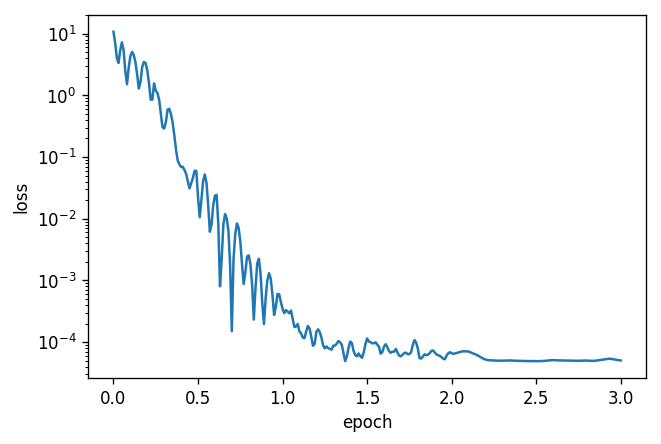

In [4]:
train(batch_size=10, lr=0.2, mom=0.9, epochs=3, period=10)

## Next
[Momentum with Gluon](../chapter06_optimization/momentum-gluon.ipynb)

For whinges or inquiries, [open an issue on  GitHub.](https://github.com/zackchase/mxnet-the-straight-dope)